# [Машина (метод) опорных векторов](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%BF%D0%BE%D1%80%D0%BD%D1%8B%D1%85_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BE%D0%B2)

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Основная идея метода

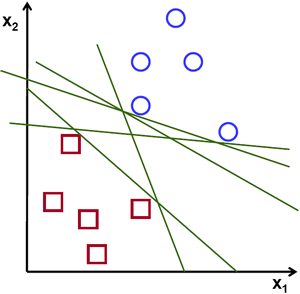

In [2]:
Image("img/svm_planes.png")

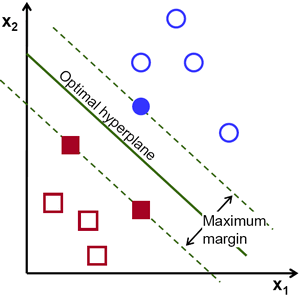

In [3]:
Image("img/svm_opt_plane.png")

**Основная идея метода** (из Википедии) — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с максимальным зазором в этом пространстве. Две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, максимизирующая расстояние до двух параллельных гиперплоскостей. Алгоритм работает в предположении, что чем больше разница или расстояние между этими параллельными гиперплоскостями, тем меньше будет средняя ошибка классификатора. 

### Список используемых терминов
- **Вектор** - точка в многомерном пространстве. Соответствует одному объекту обучающей или тестовой выборки. В рассматриваемом примере это двухмерное пространство $(x_1, x_2)$
- **Опорный вектор** - такая точка, которая участвует в построении оптимальной гиперплоскости.
- **[Гиперплоскость](https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%BB%D0%BE%D1%81%D0%BA%D0%BE%D1%81%D1%82%D1%8C)** - подпространство с размерностью, на единицу меньшей, чем объемлющее пространство. Для двухмерного пространства (плоскости) частным случаем гиперплоскости является прямая, для трехмерного пространства гиперплоскостью является плоскость.
- **Разделяющая гиперплоскость** - гиперплоскость, которая каким-то образом разделяет вектора (точки в многомерном пространстве), принадлежащие различным классам. Возможно, разделяет с ошибками.
- **Оптимальная (разделяющая) гиперплоскость** - такая разделяющая гиперплоскость, которая обеспечивает максимальный зазор (margin) между векторами (точками) различных классов.

Примеры гиперплоскостей для двухмерного и трехмерного пространства


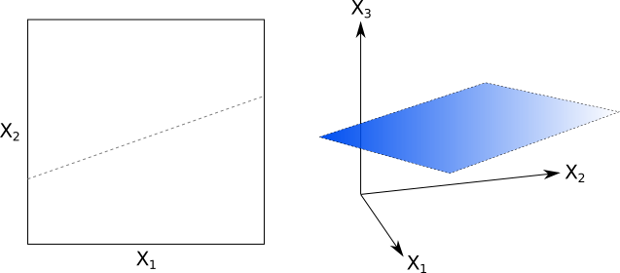

In [4]:
print('Примеры гиперплоскостей для двухмерного и трехмерного пространства')
Image("img/hyperplanes.png")

- **На этапе обучения (fit)** по точкам (векторам) обучающей выборки строится уравнение оптимальной разделяющей гиперплоскости. Это сложная задача, которая решается с применением методов оптимизации.
- **На этапе предсказания (predict)** точка тестовой выборки подставляется в полученное уравнение и определяется класс, к которому принадлежит точка.

## Математические основы метода

## Задача классификации

### Классификатор

Рассмотрим уравнение гиперплоскости для двухмерного случая:

$$ y = k \cdot x + b $$

Произведем замены:

$$ x \rightarrow x_1 $$
$$ y \rightarrow x_2 $$
$$ b \rightarrow \frac{w_0}{w_2} $$
$$ k \rightarrow -\frac{w_1}{w_2} $$

Тогда:

$$ x_2 = -\frac{w_1}{w_2} \cdot x_1 + \frac{w_0}{w_2} $$

Домножим уравнение на $w_2$ и перенесем все в левую часть:

$$ w_2 \cdot x_2 + w_1 \cdot x_1 - w_0 = 0 $$

Чтобы обобщить уравнение на многомерный случай необходимо представить $x$ и $w$ в виде многомерных векторов. Тогда:

$$ <w,x> - w_0 = 0, $$

где $<w,x>$ - скалярное произведение векторов $w$ и $x$.

При этом вектор $w$ будет являться перпендикуляром к разделяющей гиперплоскости.

Модуль расстояния от гиперплоскости до начала координат равен $\frac{w_0}{||w||}$.

Каждому вектору (объекту обучающей выборки) $x_i$ можно сопоставить результирующий класс бинарного классификатора $y_i$, который можно трактовать как знак:

$$ (<w,x_i> - w_0) \rightarrow (y_i = \{-1,+1\}) $$

или

$$ y_i(<w,x_i> - w_0) = sign(<w,x_i> - w_0) = \{-1,+1\} $$

где $ sign(...) = \{-1,+1\} $ - функция определения знака, которая задает порог.

Тогда мы строим линейный пороговый классификатор: 

$$ CLASS(x_i) = sign(<w,x_i> - w_0), $$



### Нормировка классификатора и ширина разделяющей полосы

Алгоритм работы классификатора $CLASS(x_i)$ не изменится, если его параметры $w$ и $w_0$ одновременно умножить на константу. После умножения получим новые значения $w'$ и $w_0'$.

Константу удобно выбрать таким образом, чтобы выполнялось условие:

$$ <w',x_i> - w_0' = y_i = \{-1,+1\} $$

Далее заменим $w' \rightarrow w$ и $w_0' \rightarrow w_0$ чтобы вернуться к исходным обозначениям.

Вспомним, что оптимальная гиперплоскость проходит посередине между двух ограничивающих гиперплоскостей, которые создают зазор:

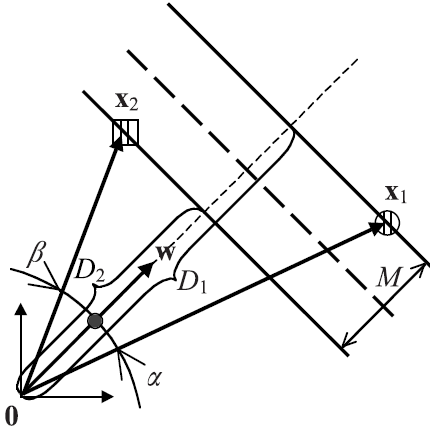

In [5]:
Image("img/svm_opt_plane_angle.png")

Тогда уравнения ограничивающих гиперплоскостей:

$$ <w,x_i> - w_0 = 1 $$

и

$$ <w,x_i> - w_0 = -1 $$

Полоса, разделяющая классы определяется условием:

$$ -1 <  \langle w,x_i \rangle - w_0  < 1 $$

Пусть вектор $x_2$ относится к отрицательному классу $y(x_2)=-1$, 
а вектор $x_1$ относится к положительному классу $y(x_1)=1$.

Тогда ширина разделяющей полосы $Margin$ является проекцией разности векторов на перпендикуляр к разделяющей гиперплоскости:

$$Margin = Projection_w (x_1 - x_2) $$

Тогда:

$$ D_1 = ||x_1|| \cdot cos(\alpha) $$
$$ D_2 = ||x_2|| \cdot cos(\beta) $$
$$ Margin = D_1 - D2 $$

Но по свойствам скалярного произведения:

$$ cos(\alpha) = \frac{\langle w,x_1 \rangle}{||x_1|| \cdot ||w||} $$

$$ cos(\beta) = \frac{\langle w,x_2 \rangle}{||x_2|| \cdot ||w||} $$

Тогда: 

$$ Margin = D_1 - D_2 = \frac{\langle w,x_1 \rangle - \langle w,x_2 \rangle}{||w||} $$

Вектора $x_1$ и $x_2$ являются опорными, а значит лежат на ограничивающих гиперплоскостях. Следовательно для вектора $x_1$:

$$ \langle w,x_1 \rangle - w_0 = 1$$
$$ \langle w,x_1 \rangle = w_0 + 1$$

Аналогично для вектора $x_2$:

$$ \langle w,x_2 \rangle - w_0 = -1$$
$$ \langle w,x_2 \rangle = w_0 - 1$$

Тогда: 

$$ Margin = D_1 - D_2 = \frac{\langle w,x_1 \rangle - \langle w,x_2 \rangle}{||w||} = \frac{(w_0+1)-(w_0-1)}{||w||} = \frac{2}{||w||}$$


Чтобы ширина разделяющей полосы была максимальной, нужно минимизировать $||w||$.

Далее можно рассмотреть два случая:

1. **Случай линейной разделимости.** Идеальное решение задачи. В этом случае ни одна из точек не попадает внутрь разделяющей полосы.
1. **Случай линейной неразделимости.** Более частый случай на практике, когда часть точек все-таки попадает внутрь разделяющей полосы. Но необходимо сделать так, чтобы количество таких точек было минимально.

### Случай линейной разделимости (hard-margin)

$$
\left \{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
||w||^2 = \langle w,w \rangle \rightarrow min \\
y_i \Big( \langle w,x_i \rangle - w_0 \Big) \geqslant 1, i=1..k
\end{array}
\right.
$$

Первое уравнение говорит о том, что мы решаем задачу минимизации $w$.

Первое уравнение говорит о том, что все точки (вектора) должны лежать за пределами разделяющей полосы. $w$.

По [теореме Каруша—Куна—Таккера](https://ru.wikipedia.org/wiki/%D0%A3%D1%81%D0%BB%D0%BE%D0%B2%D0%B8%D1%8F_%D0%9A%D0%B0%D1%80%D1%83%D1%88%D0%B0_%E2%80%94_%D0%9A%D1%83%D0%BD%D0%B0_%E2%80%94_%D0%A2%D0%B0%D0%BA%D0%BA%D0%B5%D1%80%D0%B0) эта задача эквивалентна двойственной задаче поиска седловой точки функции Лагранжа:

$$
\left \{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
L(w, w_0; \lambda) = \frac{1}{2} \langle w,w \rangle - \sum\limits_{i=1}^k \lambda_i ( y_i (\langle w,x_i \rangle - w_0) -1) \rightarrow min_{w, w_0} max_{\lambda} \\
\lambda_i \geqslant 0, i=1..k \\
\lambda_i = 0, либо (\langle w,x_i \rangle - w_0 = y_i), i=1..k 
\end{array}
\right.
$$

где $\lambda_i$ - [множители Лагранжа.](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BC%D0%BD%D0%BE%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%B9_%D0%9B%D0%B0%D0%B3%D1%80%D0%B0%D0%BD%D0%B6%D0%B0)

Третье уравнение называется условием дополняющей нежесткости.

Необходимым условием седловой точки является равенство нулю производных Лагранжиана:

$$ \frac{\partial L}{\partial w} = w - \sum\limits_{i=1}^k \lambda_i y_i x_i = 0 $$

Следовательно:

$$ w = \sum\limits_{i=1}^k \lambda_i y_i x_i $$

И

$$ \frac{\partial L}{\partial w_0} = - \sum\limits_{i=1}^k \lambda_i y_i = 0 $$

Следовательно:

$$ \sum\limits_{i=1}^k \lambda_i y_i = 0 $$

Искомый вектор весов $w$ является линейной комбинацией векторов обучающей выборки, причем только тех, для которых $\lambda_i \ne 0$. Согласно
условию дополняющей нежесткости на этих векторах $x_i$ ограничения-неравенства обращаются в равенства: $\langle w,x_i \rangle - w_0 = y_i$, следовательно, эти вектора находятся на границе разделяющей полосы. Все остальные векторы отстоят дальше от границы и не участвуют в сумме. Алгоритм не изменился бы, если бы этих векторов вообще не было в обучающей выборке.

Если $\lambda_i > 0$ и $\langle w,x_i \rangle - w_0 = y_i$, то объект обучающей выборки $x_i$ называется опорным вектором.

Подставляя условия равенства производнях нулю обратно в Лагранжиан, получаем эквивалентную задачу квадратичного программирования, содержащую только двойственные переменные:

$$
\left \{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
-L(\lambda) = - \sum\limits_{i=1}^k \lambda_i + \frac{1}{2} \sum\limits_{i=1}^k \sum\limits_{j=1}^k \lambda_i \lambda_j y_i y_j \langle x_i,x_j \rangle \rightarrow min_{\lambda} \\
\lambda_i \geqslant 0, i=1..k \\
\sum\limits_{i=1}^k \lambda_i y_i = 0
\end{array}
\right.
$$

Известно, что данная задача имеет единственное решение и тогда $w$ и $w_0$ можно найти на основании следующих формул:

$$ w = \sum\limits_{i=1}^k \lambda_i y_i x_i $$

$$ w_0 = \langle w,x_i \rangle - y_i $$

Тогда алгоритм классификации может быть записан в следующем виде:

$$ CLASS(x_i) = sign \Big( \sum\limits_{i=1}^k \lambda_i y_i \langle x_i,x \rangle - w_0 \Big) $$

При этом суммирование идёт не по всей выборке, а только по опорным векторам, для которых $\lambda _{i} \neq 0$.




### Случай линейной неразделимости (soft-margin)

В данном случае необходимо смягчить условия линейной разделимости. Набор дополнительных переменных $\xi_i \geqslant 0$ характеризует величину ошибки на объектах $x_i$.

Тогда задача оптимизации записывается следующим образом:

$$
\left \{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
\frac{1}{2}\langle w,w \rangle + C \sum\limits_{i=1}^k \xi_i \rightarrow min_{w,w_0, \xi} \\
y_i \Big( \langle w,x_i \rangle - w_0 \Big) \geqslant 1 - \xi_i, i=1..k \\
\xi_i \geqslant 0, i=1..k
\end{array}
\right.
$$

Проведя рассуждения, аналогичные случаю линейной разделимости получаем эквивалентную задачу квадратичного программирования, содержащую только двойственные переменные:

$$
\left \{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
-L(\lambda) = - \sum\limits_{i=1}^k \lambda_i + \frac{1}{2} \sum\limits_{i=1}^k \sum\limits_{j=1}^k \lambda_i \lambda_j y_i y_j \langle x_i,x_j \rangle \rightarrow min_{\lambda} \\
0 \leqslant \lambda_i \leqslant C, i=1..k \\
\sum\limits_{i=1}^k \lambda_i y_i = 0
\end{array}
\right.
$$


В данном случае алгоритм классификации также может быть записан в виде:

$$ CLASS(x_i) = sign \Big( \sum\limits_{i=1}^k \lambda_i y_i \langle x_i,x \rangle - w_0 \Big) $$

Но теперь ненулевыми $\lambda_i$ обладают не только опорные объекты, но и объекты-нарушители. Это можно считать недостатком метода, потому что  нарушителями часто оказываются шумовые выбросы, и построенное на них решающее правило опирается на шумовые данные.

Константа $C$ обычно выбирается с помощью кросс-валидации.

Очень важно то, что в решение входят не сами признаки $x_i$, а их скалярные произведения $\langle x_i,x \rangle$. Это позволяет ускорить работу метода в том случае, когда можно представить признаки в виде скалярных произведений. На этом же принципе основан "ядерный трюк".

### Использование SVM для нелинейных разделяющих поверхностей или "ядерный трюк" (kernel trick)

Основная идея состоит в том, что в скалярное произведение можно подставить не сам признак, а некоторую функцию от признака. Функция может переводить признак в пространство большей размерности и SVM начинает вычислять нелинейную разделяющую поверхность.

Пусть есть некоторое преобразование $ \phi: X \rightarrow H $, где $H$ - пространство, на котором определено скалярное произведение.

Тогда функция $K : X \times X \rightarrow R $ называется ядром, если она представима в виде $ K(x,x') = \langle \phi(x),\phi(x') \rangle $.

По [теореме Мерсера](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%9C%D0%B5%D1%80%D1%81%D0%B5%D1%80%D0%B0) функция является ядром тогда и только тогда, когда она симметрична (1) и неотрицательно определена (2):

$$ 1) K(x,x') = K(x',x) $$
$$ 2) \int_{X} \int_{X} K(x,x')g(x)g(x')dxdx' \geqslant 0 $$

для любой функции $g : X \rightarrow R$.

#### Примеры ядерных функций:

Линейная (ядро не используется):

$$ K(x,x') = \langle x,x' \rangle $$

Полиномиальная:

$$ K(x,x') = \Big(\gamma \langle x,x' \rangle + coef0\Big)^{degree} $$

Радиальная базисная функция (rbf):

$$ K(x,x') = e^{-\gamma ||x-x'||^2}, \gamma > 0$$

Сигмоидальная:

$$ K(x,x') = tanh\Big(\gamma \langle x,x' \rangle + coef0\Big) $$

## Особенности использования SVM для задач регрессии

Данный метод называется SVR - Support Vector machine Regression.

В этом случае $y_i$ рассматривается как действительное значение и вместо функции $sign( \langle w,x_i \rangle - w_0)$ также вычисляется действительная функция $\langle w,x_i \rangle - w_0$.

Для применения SVM к задаче регрессии используется следующая постановка:

$$
\left \{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
||w||^2 = \langle w,w \rangle \rightarrow min \\
y_i - \langle w,x_i \rangle - w_0 \leqslant \epsilon \\
\langle w,x_i \rangle + w_0 - y_i \leqslant \epsilon 
\end{array}
\right.
$$

где $\epsilon$ - порог, все значения, попадающие в $\epsilon$-окрестность считаются верными.

### Преимущества метода:
- Метод показывает очень хорошие практические результаты.
- Задача выпуклого квадратичного программирования имеет единственное  решение.
- С использованием "ядерного трюка" возможно построение нелинейных разделяющих поверхностей.

### Недостатки метода:
- Метод чувствителен к обучающей выборке (в том числе к выбросам в данных), так как гиперплоскость строится на опорных векторах (граничных точках). Если в обучающую вылорку попали другие точки, то гиперплоскость может быть построена иначе. 
- Нет общего подхода к оптимизации ядер под конкретную задачу.
- Необходимо подбирать гиперпараметры.

## Реализация в [scikit-learn](https://scikit-learn.org/stable/modules/svm.html)

### Для решения задачи классификации используются классы:
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) - основной классификатор на основе SVM. Поддерживает различные ядра.
- [NuSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html) - разновидность SVC с поддержкой параметра nu ($\nu \in (0,1]$), который определяет нижнюю границу доли опорных векторов.
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) - линейный классификатор на основе SVM. Не поддерживает ядра, работает быстрее других методов.

In [6]:
# Используем датасет iris с двумя первыми признаками
iris = load_iris()
iris_X = iris.data[:, :2]
iris_y = iris.target

In [7]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(iris_X, iris_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = iris_X[:, 0], iris_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=iris_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

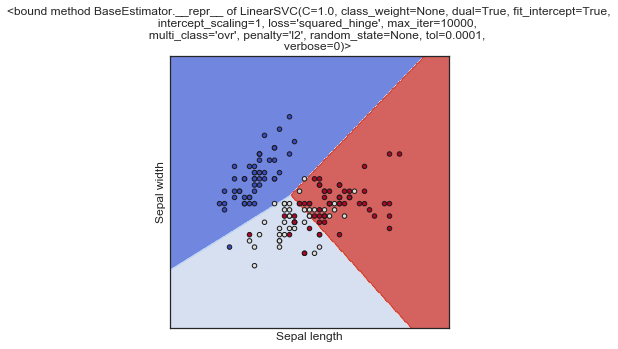

In [8]:
plot_cl(LinearSVC(C=1.0, max_iter=10000))

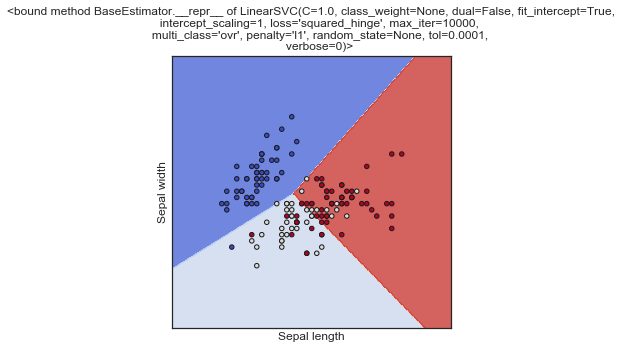

In [9]:
plot_cl(LinearSVC(C=1.0, penalty='l1', dual=False, max_iter=10000))

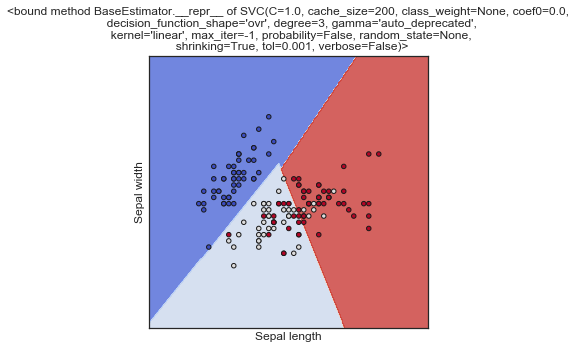

In [10]:
plot_cl(SVC(kernel='linear', C=1.0))

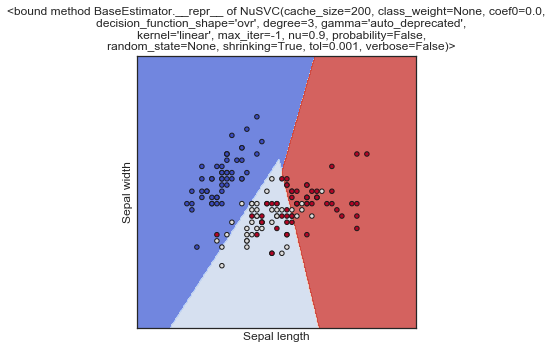

In [11]:
plot_cl(NuSVC(kernel='linear', nu=0.9))

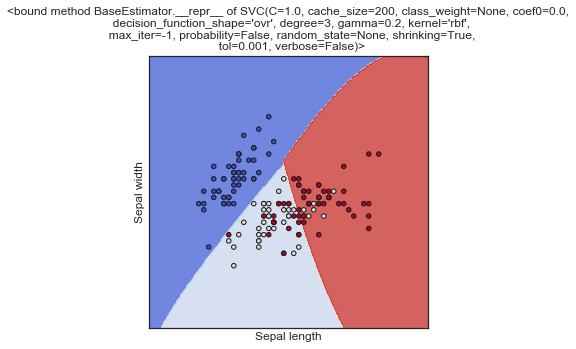

In [12]:
plot_cl(SVC(kernel='rbf', gamma=0.2, C=1.0))

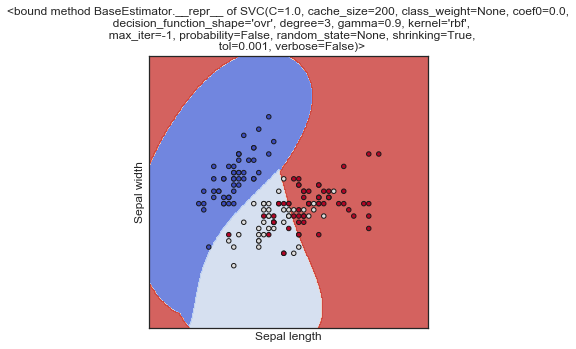

In [13]:
plot_cl(SVC(kernel='rbf', gamma=0.9, C=1.0))

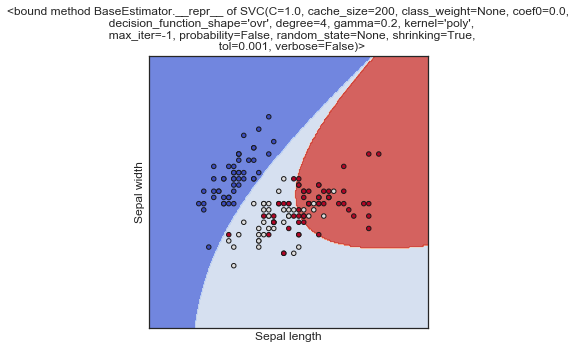

In [14]:
plot_cl(SVC(kernel='poly', degree=4, gamma=0.2, C=1.0))

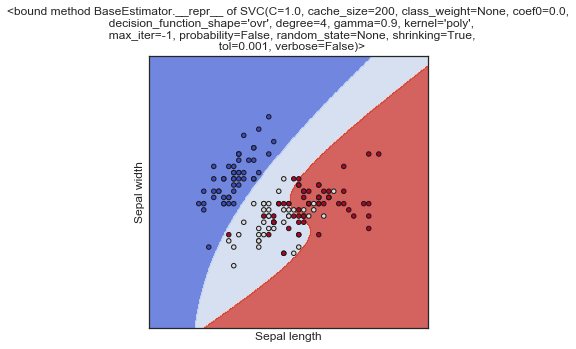

In [15]:
plot_cl(SVC(kernel='poly', degree=4, gamma=0.9, C=1.0))

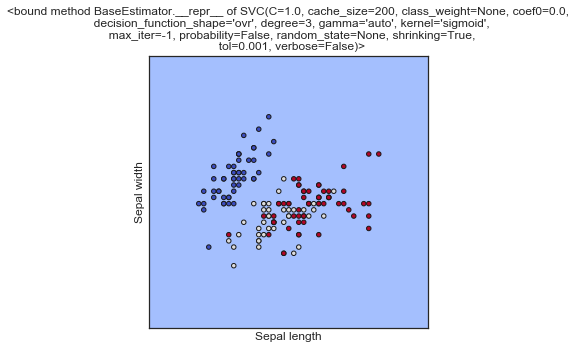

In [16]:
plot_cl(SVC(kernel='sigmoid', gamma='auto', C=1.0))

### Для решения задачи регрессии используются классы:
- [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) - основной регрессор на основе SVM. Поддерживает различные ядра.
- [NuSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html) - разновидность SVR с поддержкой параметра nu ($\nu \in (0,1]$), который определяет нижнюю границу доли опорных векторов.
- [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) - линейный регрессор на основе SVM. Не поддерживает ядра, работает быстрее других методов.

In [17]:
boston = load_boston()
df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
df_boston['target'] = pd.Series(boston.target)
boston_x = df_boston['RM'].values
boston_y = df_boston['target'].values

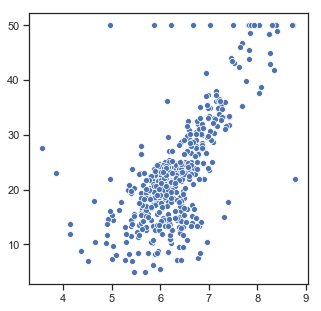

In [18]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=boston_x, y=boston_y)

In [19]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(boston_x.reshape(-1, 1), boston_y)
    boston_y_pred = clf.predict(boston_x.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(boston_x, boston_y, 'b.')
    ax.plot(boston_x, boston_y_pred, 'ro')
    plt.show()

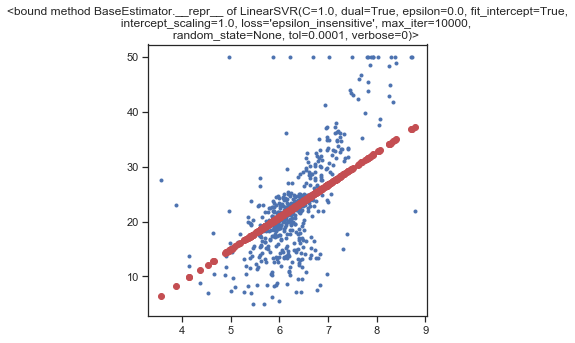

In [20]:
plot_regr(LinearSVR(C=1.0, max_iter=10000))

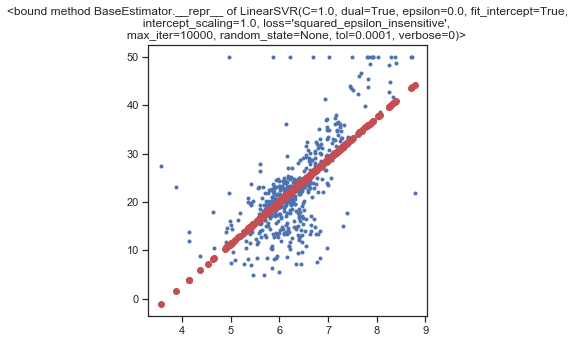

In [21]:
plot_regr(LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=10000))

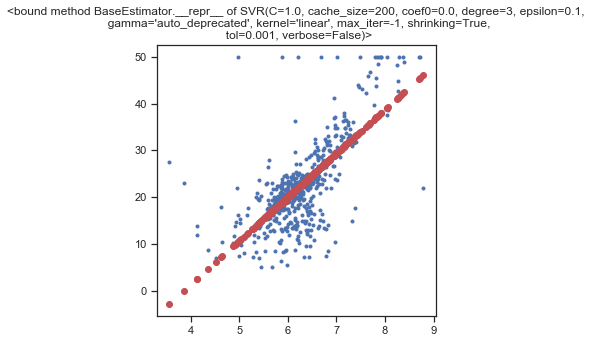

In [22]:
plot_regr(SVR(kernel='linear', C=1.0))

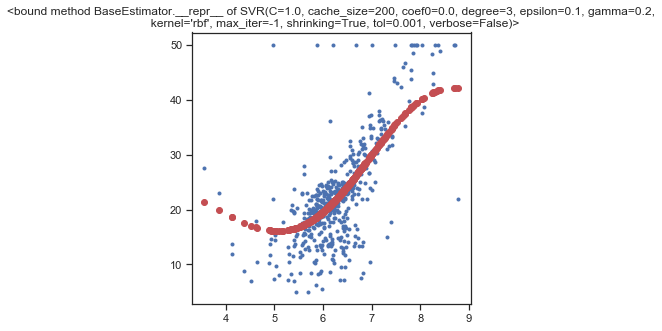

In [23]:
plot_regr(SVR(kernel='rbf', gamma=0.2, C=1.0))

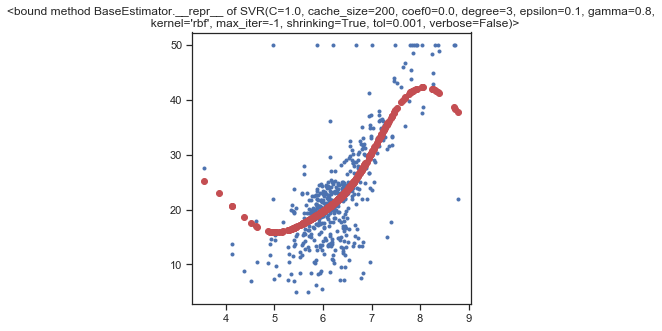

In [24]:
plot_regr(SVR(kernel='rbf', gamma=0.8, C=1.0))

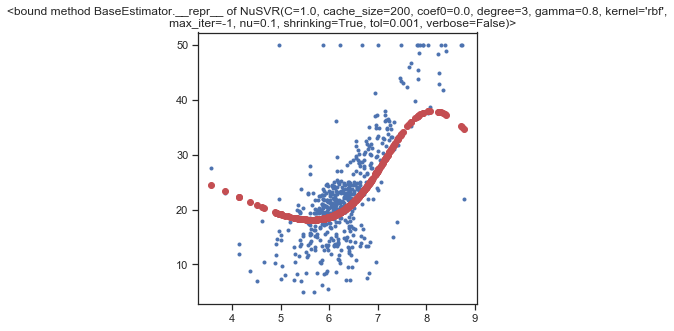

In [25]:
plot_regr(NuSVR(kernel='rbf', gamma=0.8, nu=0.1, C=1.0))

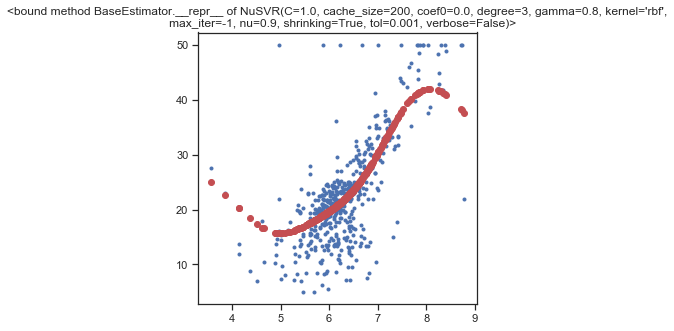

In [26]:
plot_regr(NuSVR(kernel='rbf', gamma=0.8, nu=0.9, C=1.0))

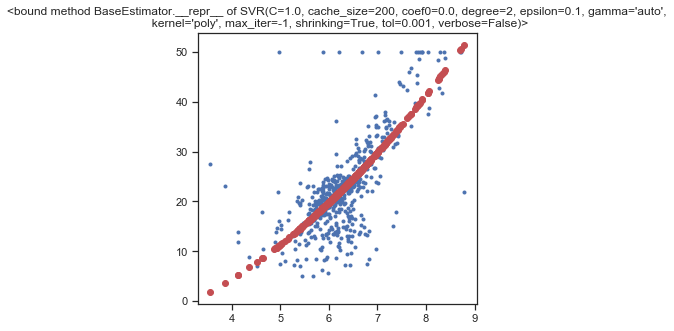

In [27]:
plot_regr(SVR(kernel='poly', degree=2, gamma='auto', C=1.0))

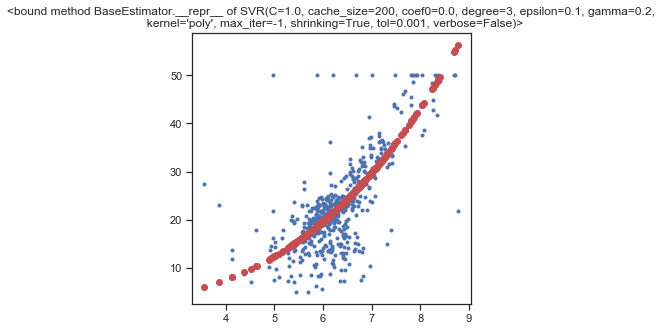

In [28]:
plot_regr(SVR(kernel='poly', degree=3, gamma=0.2, C=1.0))

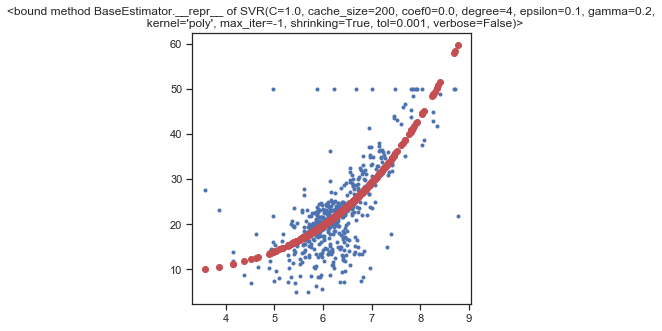

In [29]:
plot_regr(SVR(kernel='poly', degree=4, gamma=0.2, C=1.0))

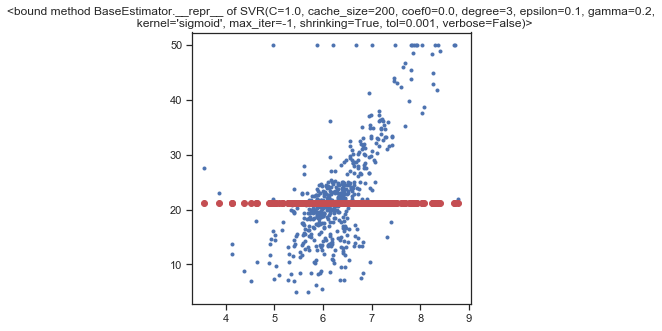

In [30]:
plot_regr(SVR(kernel='sigmoid', gamma=0.2, C=1.0))

### Обнаружение аномалий с помощью класса [OneClassSVM.](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)

Задача обнаружения аномалий рассматривается как задача бинарной классификации. Нормальные значения помечаются классом +1, а аномальные значения (выбросы) - классом -1.

Задача относится к классу задач обучения без учителя. Метод fit не сопоставляет X и y, а изучает выборку и пытается провести границу между нормальными и аномальными значениями.

In [31]:
anom_cl = OneClassSVM()
anom_cl.fit(boston_x.reshape(-1, 1))
np.unique(anom_cl.predict(boston_x.reshape(-1, 1)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([-1,  1], dtype=int64)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


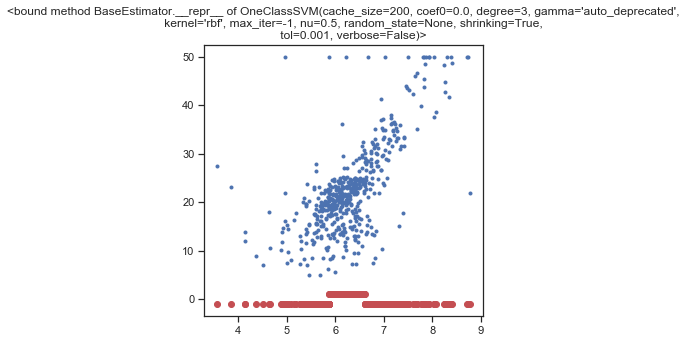

In [32]:
plot_regr(OneClassSVM())

## Дополнительные источники

### Рекомендуемые

- Видеолекции [1](https://www.youtube.com/watch?v=Adi67_94_gc) и [2](https://www.youtube.com/watch?v=51k2xilkAbs) профессора К.В. Воронцова на youtube
- [Текст лекции профессора К.В. Воронцова](http://www.ccas.ru/voron/download/SVM.pdf)
- [Презентация к лекции](http://www.machinelearning.ru/wiki/images/a/a0/Voron-ML-Lin-SVM.pdf) профессора К.В. Воронцова
- [Описание метода на machinelearning.ru](http://www.machinelearning.ru/wiki/index.php?title=SVM)
- [Курс лекций](http://www.uic.unn.ru/~zny/ml/) Н.Ю.Золотых по машинному обучению. В [презентации](http://www.uic.unn.ru/~zny/ml/Course/ml_pres.pdf) в том чиcле рассматривается метод SVM.
- [Support Vector Machine introduction](https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/)
- Свободно распространяемая книга [SVM Succinctly](http://jermmy.xyz/images/2017-12-23/support_vector_machines_succinctly.pdf)

### Вспомогательные

- https://www.quantstart.com/articles/Support-Vector-Machines-A-Guide-for-Beginners
- https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47
- https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
- https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
- https://pythonspot.com/support-vector-machine/
- https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
- https://www.kaggle.com/revannth/support-vector-regression-using-python